# Part II - Prosper Loan Data Exploration
## by Duke Ta


## Investigation Overview

The following analysis looks into a couple of variables which will try to divide the borrowers into different group which can expect to receive different interest rates and loan amounts. Also, some efforts are made within the analysis to associate the faulty rate with different characteristics of the borrower


## Dataset Overview

The loans dataset contains 113k+ Prosper loans from the period 2005-2014 and 81 variables. Prosper is a US peer-to-peer landing company founded in 2005, so the dataset covers the first years of their business. The data collection went through changes in 2009, which we kept in mind during the investigation.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
# set base color for plots
base_color = sns.color_palette()[0]

In [2]:
# load in the dataset into a pandas dataframe and made all the modification in the exploratory process
df_all = pd.read_csv('prosperLoanData.csv')
df_all=df_all.drop_duplicates(subset='ListingKey')
df_all=df_all.drop(df_all[df_all['LoanStatus'] == 'Cancelled'].index)
df = df_all[['ListingKey','Term','LoanOriginationDate','LoanStatus','ClosedDate',
            'BorrowerRate','CreditGrade','ProsperRating (Alpha)', 'StatedMonthlyIncome','EmploymentStatus'
            ,'IncomeRange','IncomeVerifiable', 'LoanOriginalAmount' , 'Recommendations',
            'Investors','IsBorrowerHomeowner']]
df.drop(df[df['LoanOriginationDate'] > df['ClosedDate']].index, inplace=True)
df['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'])
df['ClosedDate'] = pd.to_datetime(df['ClosedDate'])
mapping = {'Completed': 'Completed', 'Current': 'Current', 'FinalPaymentInProgress' :'Current',
          'Defaulted': 'Fault', 'Chargedoff':'Fault'}
df['LoanType'] = df['LoanStatus'].map(mapping).fillna('Past Due')
df['LoanSpan'] = ((df.ClosedDate - df.LoanOriginationDate) / np.timedelta64(1, 'M'))
df['CreditRating'] = np.where(df.CreditGrade.isnull(), df['ProsperRating (Alpha)'], df.CreditGrade)
credit_rating = {'Category': ['AA', 'A', 'B', 'C', 'D', 'E', 'HR', 'NC']}
df.CreditRating = df['CreditRating'].astype(pd.api.types.CategoricalDtype(ordered=True, categories = credit_rating['Category']))
df1=df[df['LoanType'] != 'Current']
income_range = {'Category': ['$100,000+', '$75,000-99,999', '$50,000-74,999', '$1-24,999', '$0', 'Not employed', 'Not displayed']}
df.IncomeRange = df['IncomeRange'].astype(pd.api.types.CategoricalDtype(ordered=True, categories = income_range['Category']))
Loan_Status = {'Category': ['Completed', 'Current','FinalPaymentInProgress', 'Past Due (1-15 days)',
                            'Past Due (31-60 days)', 'Past Due (61-90 days)',
                            'Past Due (91-120 days)', 'Past Due (>120 days)', 'Defaulted', 'Chargedoff']}
df.LoanStatus = df['LoanStatus'].astype(pd.api.types.CategoricalDtype(ordered=True, categories = Loan_Status['Category']))
Loan_Type = {'Category': ['Completed','Current','Past Due','Fault']}
df.LoanType = df['LoanType'].astype(pd.api.types.CategoricalDtype(ordered=True, categories = Loan_Type['Category']))
Loan_Type_df1 = {'Category': ['Completed','Past Due','Fault']}
df1.LoanType = df1['LoanType'].astype(pd.api.types.CategoricalDtype(ordered=True, categories = Loan_Type_df1['Category']))

numeric_vars = ['BorrowerRate', 'LoanOriginalAmount','StatedMonthlyIncome'
                ,'LoanSpan', 'Term','Investors','Recommendations']
bool_vars = ['IncomeVerifiable','IsBorrowerHomeowner']
ordered_categoric_vars = ['IncomeRange', 'CreditRating','LoanStatus','LoanType']


## LoanType
The LoanStatus column describe the state of the loan, about whether it is completed, defaulted or pastdue
> Most of the Loans are Current Loans and Past Due loan are divided into different values depend on the period. So to convenience for later analysis, i group up the values into 4 type: Completed, Fault ( include Defaulted and Chargedoff), Current and PastDue and stored them in "LoanType" column. Since the proportion Current Loan is significant, some visulizations will eliminate this value to focus on the objective of assesing defaulted loan

Looking at the visulization, we can see that the ratio between Fault Loan and Past Due compare to Completed Loan is quite high. This indicate the necessary for an efficent risk rating system.

The distribution of Loan type across year is quite interesting too, the rate of fault loan is minimize in 2009, 2010 which associate with the 2008 global crisis, the loan policies in such time must have been tighten.

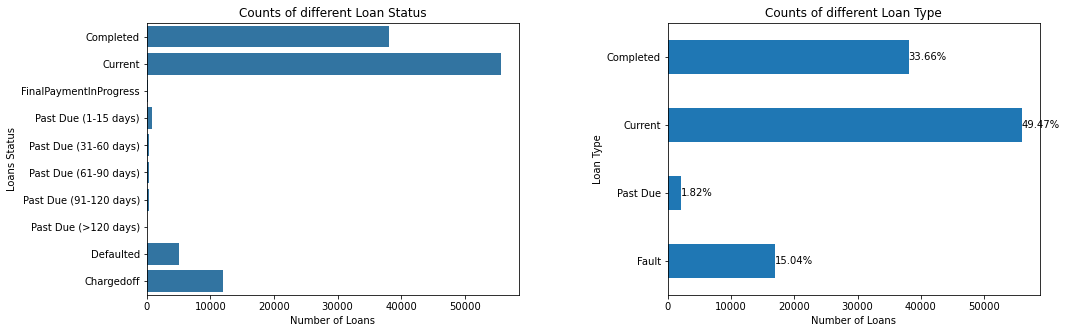

In [3]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)

# Create plot for  of LoanStatus
Loan_Status_df = df.LoanStatus.value_counts()
sns.countplot(data=df[df['LoanStatus'].isin(Loan_Status_df.index)],
              y='LoanStatus', order=Loan_Status['Category'], color=base_color)
plt.xlabel('Number of Loans')
plt.ylabel('Loans Status');
plt.title("Counts of different Loan Status")

# Create plot for LoanType
plt.subplot(1,2,2)
total_sum = len(df['LoanType'])
value_counts = df['LoanType'].value_counts()
ax =value_counts.loc[Loan_Type['Category'][::-1]].plot(kind='barh')
# Add the percentage labels on top of each bar
for i, (category, count) in enumerate(value_counts.loc[Loan_Type['Category'][::-1]].items()):
    percentage = (count / total_sum) * 100
    ax.text(count + 1, i, f'{percentage:.2f}%', ha='left', va='center')
plt.xlabel('Number of Loans')
plt.ylabel('Loan Type');
plt.title("Counts of different Loan Type")
# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4);


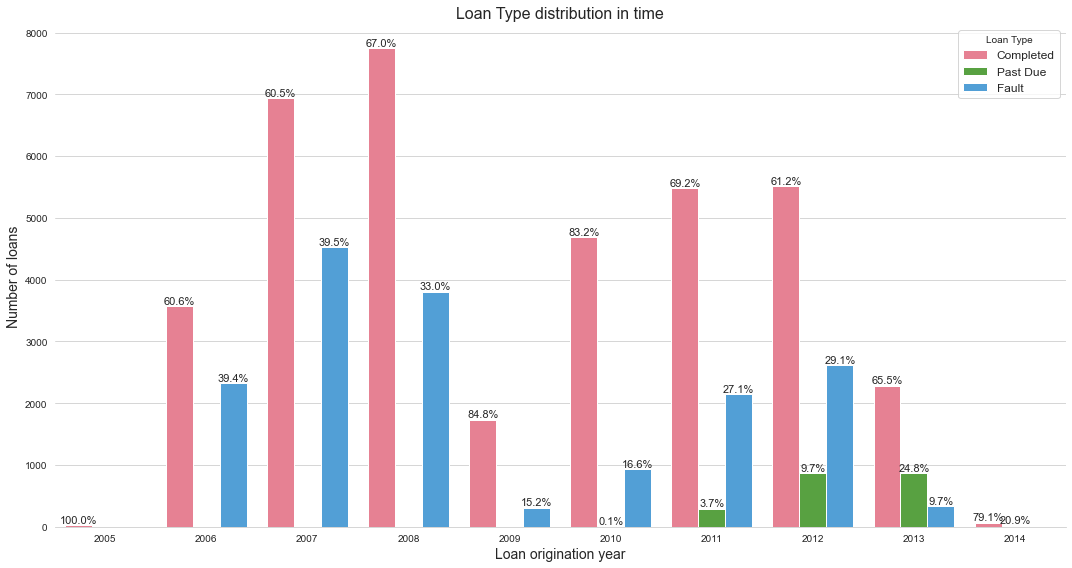

In [4]:
def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):     
            total = sum(xgroup[i] for xgroup in all_heights if not np.isnan(xgroup[i]))
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')
    
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))
ax4 = sns.countplot(data = df1, x = df1['LoanOriginationDate'].dt.year, hue = 'LoanType', palette = 'husl')
plt.xlabel('Loan origination year',fontsize=14)
plt.ylabel('Number of loans', fontsize=14)
plt.title('Loan Type distribution in time', fontsize=16)
sns.despine(left=True)
plt.legend(title = 'Loan Type', fontsize=12)
percentage_above_bar_relative_to_xgroup(ax4)
plt.tight_layout();

## Credit Rating

The Loans included in the dataset have a alpha rating system that was describe by 2 column CreditGrade and ProperRating. In which the CreditGrade is used for Loan that belong to prior 2009 and the latter was for post-2009 Loan. 

> As the level include in both rating systems was similar (CreditGrade has extra rating level for extreme risk loan), I merged them in to 1 column called Credit Rating for convienience

The distribution of loans base on rating follow a normal distribution in term of rating level, with C type loan are the most popular. This is quite interesting and justifiable consider the fact that the rating depend on borrower's background.





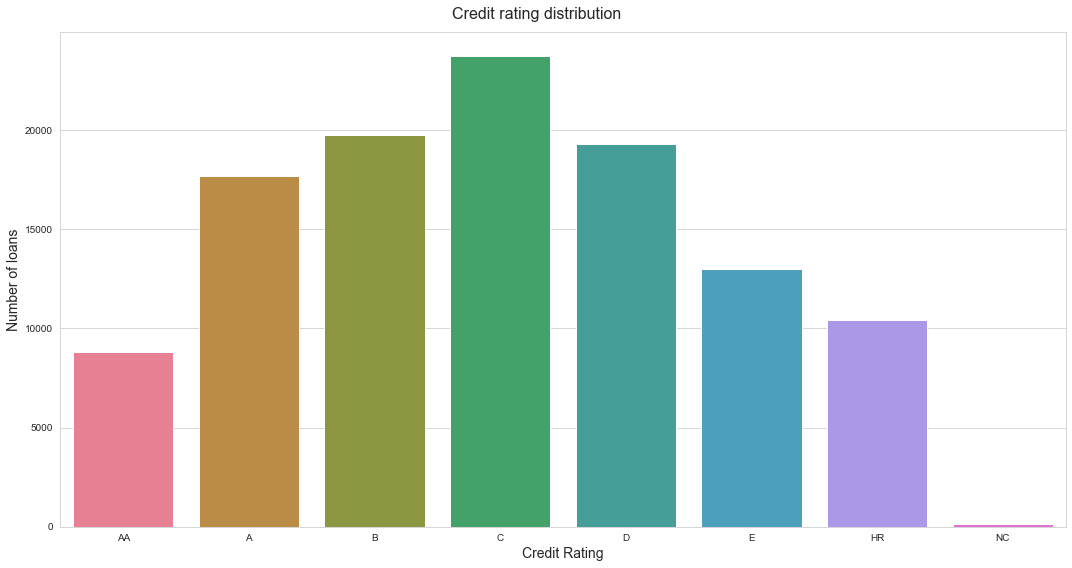

In [5]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
plt.suptitle("Credit rating distribution", fontsize=16)
sns.countplot(data = df, x = 'CreditRating', palette = 'husl')
plt.xlabel('Credit Rating',fontsize=14)
plt.ylabel('Number of loans',fontsize=14);
plt.tight_layout();

## The Effectiveness of Loan Rating System

It can be seen that the Risk Rating system work quite well as the chances of Fault Loan slowly increase as the Rating decrease. We can even see a 70% fault loan percentage in NC rating, an incredible high number. This rating would help the authority to set a appropriate loan amount and interest rate to minimize the damage caused by such cases.

We can see a little bias regarding the same pattern in Past Due loan as D type get lower rate than C type

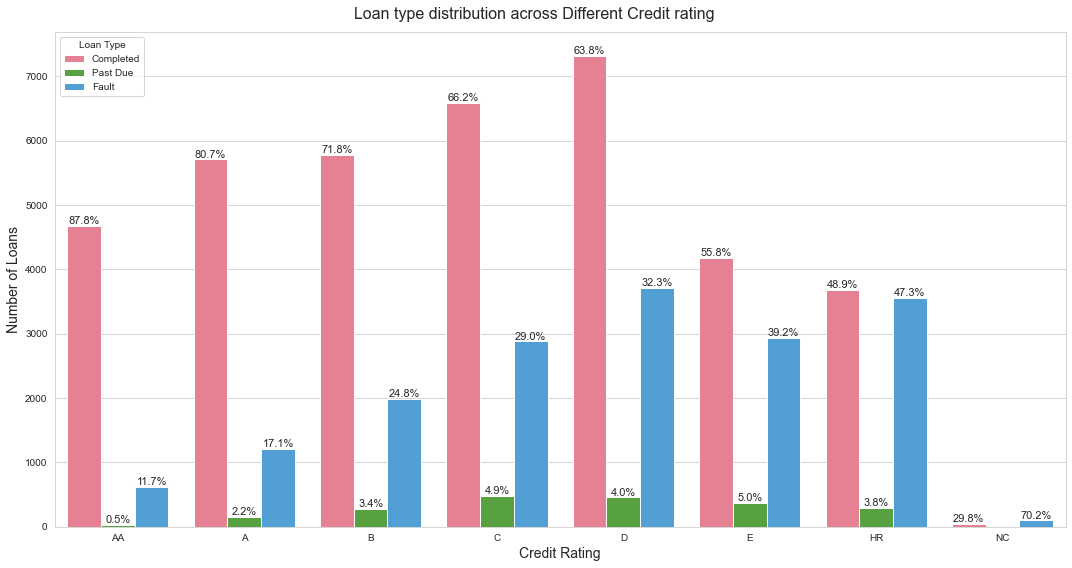

In [6]:
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")
ax3 = sns.countplot(data = df1, x = 'CreditRating', hue = 'LoanType', palette = 'husl');
ax3.set_xlabel('Credit Rating', fontsize=14)
ax3.set_ylabel('Number of Loans', fontsize=14)
plt.legend(title = 'Loan Type')
percentage_above_bar_relative_to_xgroup(ax3)
plt.suptitle("Loan type distribution across Different Credit rating ", fontsize=16)
plt.tight_layout();
plt.show()

## Loan strategies on different customer groups

As Loan Rating system working quite effectively, the strategies on loan should be evolve around this. Through the analysis of the dataset, we found strong correlation between different redit Risk groups and the interest rate and loan amount each group receive.

- Higher rating Loan clearly earn a more favourable interest rate
- Depend on the needs of the borrowers, higher rating borrowers dont neccessary need to borrow a huge a mount so we can only observe a moderate positive relationship between Loan Amount and Loan Rating at upper group. However for high risk loans, they are more likely to receive low loan amount 


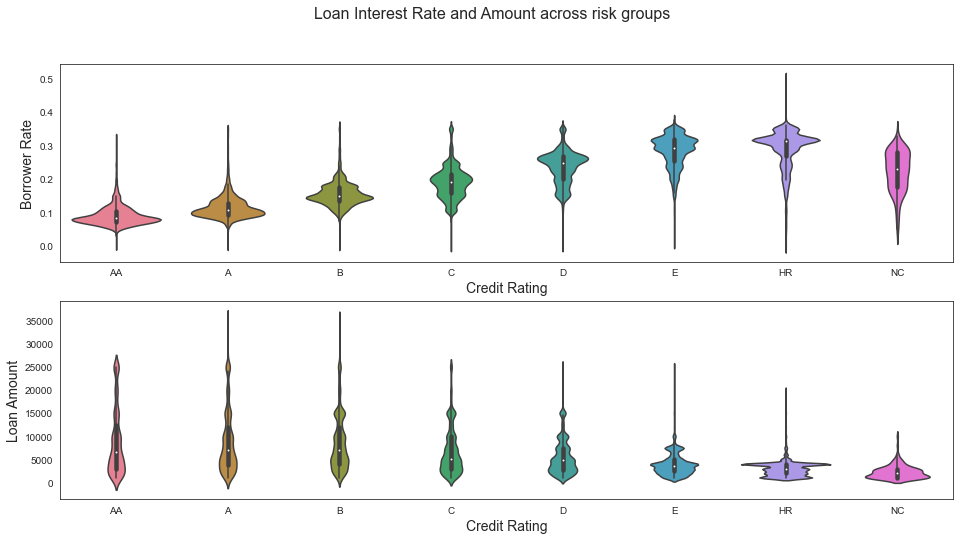

In [7]:
sns.set_style("white")
plt.figure(figsize = (16,8))
plt.suptitle('Loan Interest Rate and Amount across risk groups', size = 16)

plt.subplot(2,1,1)
ax1=sns.violinplot(data=df1, x="CreditRating", y="BorrowerRate", palette = 'husl')
ax1.set_ylabel('Borrower Rate', fontsize = 14)
ax1.set_xlabel('Credit Rating', fontsize = 14);

plt.subplot(2,1,2)
ax2=sns.violinplot(data=df1, x="CreditRating", y="LoanOriginalAmount", palette = 'husl')
ax2.set_ylabel('Loan Amount', fontsize = 14)
ax2.set_xlabel('Credit Rating', fontsize = 14);


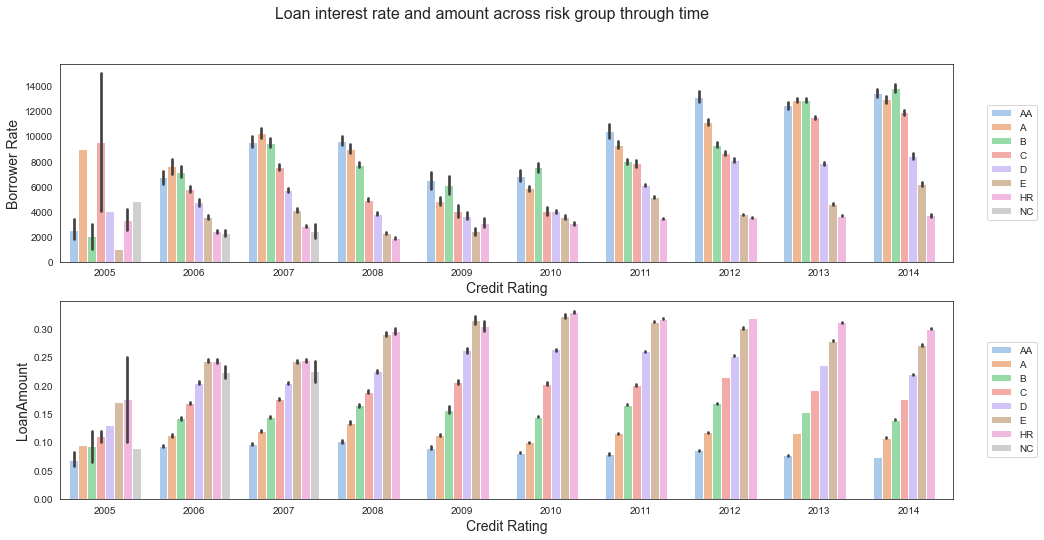

In [8]:
sns.set_style("white")
plt.figure(figsize = (16,8))
plt.suptitle('Loan interest rate and amount across risk group through time', size = 16)

#Ploting distribution of different credit rating across years
plt.subplot(2,1,1)
ax1=sns.barplot(data = df, x = df['LoanOriginationDate'].dt.year, y = 'LoanOriginalAmount', hue = 'CreditRating', palette = 'pastel')
ax1.legend(loc = 'right', bbox_to_anchor=(1.1, 0.5), ncol=1)
ax1.set_ylabel('Borrower Rate', fontsize = 14)
ax1.set_xlabel('Credit Rating', fontsize = 14);


plt.subplot(2,1,2)
ax2=sns.barplot(data = df, x = df['LoanOriginationDate'].dt.year, y = 'BorrowerRate', hue = 'CreditRating', palette = 'pastel')
ax2.legend(loc = 'right', bbox_to_anchor=(1.1, 0.5), ncol=1)
ax2.set_ylabel('LoanAmount', fontsize = 14)
ax2.set_xlabel('Credit Rating', fontsize = 14);

We can also see some clear correlation between Loan characteristic and borrower's background. This is supported by the fact that the rating system is somewhat relate to the borrower's background including: income and occupation.

> The better the borrower background, they will have more favourable interest rate and will be able to loan more

Regarding Income:
- The higher the income of borrowers, they earn lower interest rate and they get to borrow more
- Interestingly, the group that have 0 income seems to earn lower interest rate than the group that have low income. This can be explain by an assumption that the group with 0 income might be relate to old people who still have assets to pay for the loan or speacial groups in the society that benefit from certain policies (disabilities, people with small children ...)

Regarding occupation:
- People with a job seems to have better interest rate than unemployed and self-employed.

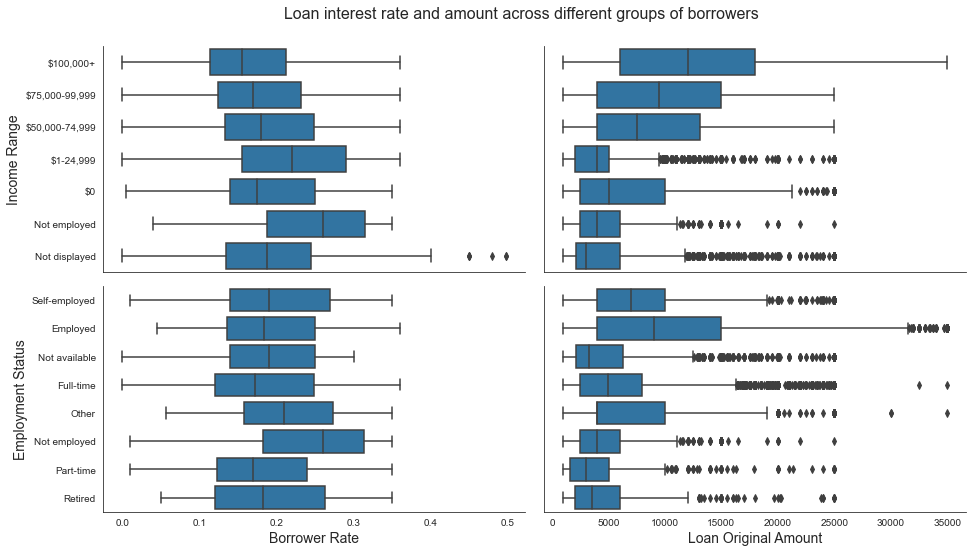

In [9]:
def boxgrid(x, y, **kwargs):
    """ Function for creating box plots with seaborn's PairGrid. """
    default_color = sns.color_palette()[0]
    sns.boxplot(x, y, color = default_color)

g = sns.PairGrid(data = df, x_vars = ['BorrowerRate', 'LoanOriginalAmount'],
                 y_vars = ['IncomeRange', 'EmploymentStatus',],
                height = 3.6, aspect = 1.8)
g.map(boxgrid)
# Set the x-axis and y-axis labels
g.axes[1, 0].set_xlabel('Borrower Rate', fontsize=14)
g.axes[1, 0].set_ylabel('Employment Status', fontsize=14)
g.axes[0, 0].set_ylabel('Income Range', fontsize=14)
g.axes[1, 1].set_xlabel('Loan Original Amount', fontsize=14)

plt.suptitle('Loan interest rate and amount across different groups of borrowers', size=16, y=1.05)
plt.show()

In [10]:
!jupyter nbconvert SlideDeck.ipynb --to slides --post serve --no-input --no-prompt --port 8888

^C
